In [16]:
import time
import soundfile
import pandas as pd
import matplotlib.pyplot as plt
from espnet2.bin.asr_inference import Speech2Text
from espnet2.bin.asr_align import CTCSegmentation

In [5]:
import torch
torch.set_num_threads(1)

## Load model

In [44]:
#longer beam size take more time but is more accurate, default is 20
speech2text = Speech2Text("exp/config.yaml", "exp/valid.acc.ave_10best.pth", quantize_asr_model=True, quantize_lm=True, beam_size=10)

## Load example audiofile to transcribe

In [45]:
speech, rate = soundfile.read("example_audio/emt16k.wav")
assert rate == 16000

In [46]:
%time text, *_ = speech2text(speech)

CPU times: user 1.71 s, sys: 9.89 ms, total: 1.72 s
Wall time: 1.75 s


In [47]:
print(text[0])

mina tahaksin homme täna ja homme kui saan kolm krampsumas ise müüki panna


In [32]:
!soxi example_audio/emt16k.wav


Input File     : 'example_audio/emt16k.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:12.74 = 203815 samples ~ 955.383 CDDA sectors
File Size      : 408k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



## Example token level alignment

In [8]:
aligner = CTCSegmentation("exp/config.yaml", "exp/valid.acc.ave_10best.pth" , kaldi_style_text=False, blank_transition_cost_zero=True)
segments = aligner(speech, text[0].split())

In [9]:
print(segments)

utt_0000 utt 0.36 0.78 -0.0001 mina
utt_0001 utt 0.78 1.19 -0.0003 tahaksin
utt_0002 utt 1.19 1.59 -0.0017 homme
utt_0003 utt 1.67 2.19 -0.0001 täna
utt_0004 utt 3.24 3.76 -0.0037 ja
utt_0005 utt 3.76 4.28 -0.0000 homme
utt_0006 utt 5.61 6.13 -0.0001 kui
utt_0007 utt 6.17 6.69 -0.0009 saan
utt_0008 utt 7.98 8.50 -0.2285 kolm
utt_0009 utt 8.50 9.34 -0.1062 krampsumas
utt_0010 utt 9.34 9.54 -0.1183 ise
utt_0011 utt 9.54 10.07 -0.2588 müüki
utt_0012 utt 10.07 10.31 -0.1041 panna



## Get timestamps with some correction

In [25]:
def get_timestamps(aligner, speech, text, time_correction=0.2):
    tokens=text.split()
    segments = aligner(speech, tokens)
    df=pd.DataFrame(segments.segments)
    df.columns=['start', 'end', 'confidence']
    df['start']=df.start+time_correction
    df['end']=df.end+time_correction
    df['words']=tokens
    return df

In [26]:
speech, rate = soundfile.read("example_audio/oden_kypsis16k_subset2.wav")
assert rate == 16000

%time text, *_ = speech2text(speech)

CPU times: user 1.68 s, sys: 0 ns, total: 1.68 s
Wall time: 1.68 s


In [27]:
!soxi example_audio/oden_kypsis16k_subset2.wav


Input File     : 'example_audio/oden_kypsis16k_subset2.wav'
Channels       : 1
Sample Rate    : 16000
Precision      : 16-bit
Duration       : 00:00:09.19 = 146983 samples ~ 688.983 CDDA sectors
File Size      : 294k
Bit Rate       : 256k
Sample Encoding: 16-bit Signed Integer PCM



In [13]:
%time df_times=get_timestamps(aligner, speech, text[0])

CPU times: user 309 ms, sys: 8.51 ms, total: 318 ms
Wall time: 312 ms


In [14]:
df_times.head(20)

start       end  confidence           words
0   0.260173  0.661328   -0.049087          klikid
1   0.661328  0.821789   -0.003573            neid
2   0.823233  1.784560   -0.001952        allserva
3   1.784560  1.985137   -0.034099         tekivad
4   2.548197  3.068255   -0.000037            need
5   3.068255  4.031025   -0.008919   lubaküpsiseid
6   4.754546  5.274604   -0.000385             mis
7   5.274604  5.415008   -0.078755              on
8   5.415008  5.555412   -0.000224            nagu
9   5.555412  5.836220   -0.000488          ilusti
10  5.836220  6.117029   -0.002274          kohati
11  6.238818  7.039684   -0.013956        tõlgitud
12  7.039684  7.240261   -0.002010           eesti
13  7.240261  7.681531   -0.002761          keelde
14  7.803320  8.323378   -0.001533             see
15  8.323378  8.644302   -0.044506            idee
16  8.644302  9.326264   -0.215737  arusaadavamaks

## Chunk audio to see how long audio increases transcripton time significantly

In [1]:
from subprocess import Popen, PIPE

In [7]:
def chunk_audio(src_file, to_file, start, end):
    proc = Popen(['sox', src_file, to_file, 'trim', str(start), f'={end}'], stdout=PIPE, stderr=PIPE)
    stdout, stderr = proc.communicate()
    return stdout, stderr

from_file='example_audio/oden_kypsis16k.wav'
to_files=[]
for i in range(5, 31):
    to_file=f'example_audio/chunks/oden_kypsis16k_chunk_{i}.wav'
    chunk_audio(from_file, to_file, 0, i)
    to_files.append(to_file)

In [38]:
chunk_times=[]
for file in to_files:
    speech, rate = soundfile.read(file)
    assert rate == 16000
    start=time.time()
    text, *_ = speech2text(speech)
    end=time.time()
    duration=end-start
    chunk_times.append([file, text[0], duration, len(speech)/16000])
df_chunk_times=pd.DataFrame(chunk_times)

In [39]:
df_chunk_times.columns=['file', 'hyp','elapsed_time', 'audio_dur_sec']
df_chunk_times['trans_time_audio_dur_share']=df_chunk_times.elapsed_time/df_chunk_times.audio_dur_sec
df_chunk_times=df_chunk_times.sort_values('audio_dur_sec')
df_chunk_times=df_chunk_times.reset_index(drop=True)
df_chunk_times.head()

file  \
0  example_audio/chunks/oden_kypsis16k_chunk_5.wav   
1  example_audio/chunks/oden_kypsis16k_chunk_6.wav   
2  example_audio/chunks/oden_kypsis16k_chunk_7.wav   
3  example_audio/chunks/oden_kypsis16k_chunk_8.wav   
4  example_audio/chunks/oden_kypsis16k_chunk_9.wav   

                                                 hyp  elapsed_time  \
0                             enamus ajast nagu klik      0.418611   
1                  enamus ajast nagu klikid neid all      0.481883   
2     enamus ajast nagu klikid neid allserva tekivad      0.700862   
3  enamus ajast nagu klikid neid allserva tekivad...      0.839978   
4  enamus ajast nagu klikid neid allserva tekivad...      1.016149   

   audio_dur_sec  trans_time_audio_dur_share  
0            5.0                    0.083722  
1            6.0                    0.080314  
2            7.0                    0.100123  
3            8.0                    0.104997  
4            9.0                    0.112905

<Axes: xlabel='elapsed_time', ylabel='audio_dur_sec'>

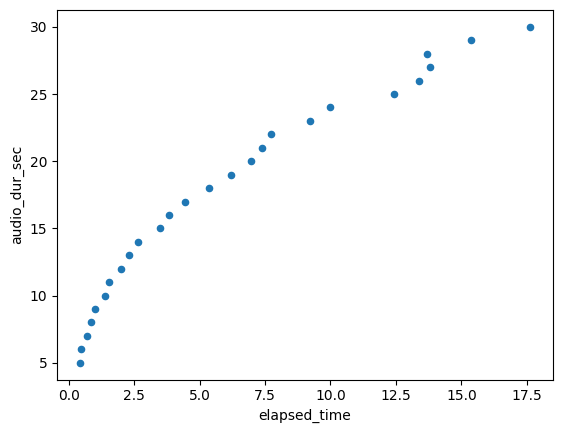

In [40]:
df_chunk_times.plot.scatter('elapsed_time', 'audio_dur_sec')

Text(0.5, 0, 'audio duration')

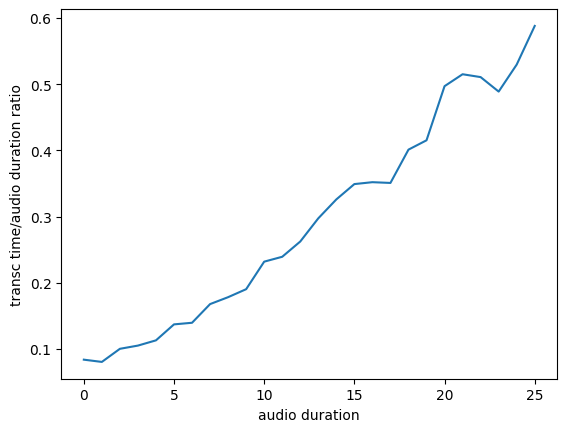

In [41]:
df_chunk_times['trans_time_audio_dur_share'].plot()
plt.ylabel('transc time/audio duration ratio')
plt.xlabel('audio duration')